In [1]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

In [8]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
bert_base_model = "uncased_L-12_H-768_A-12"
bert_models = [None, "MRPC", "CoLA", "MNLI", "RTE", "SST", "WNLI", "QQP"]

In [13]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_decoding_perfs = {}
model_global_steps = {None: 0}
for model in bert_models:
    # brain decoding results
    decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
        ("" if model is None else ".finetune-%s" % model)
    decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
    model_decoding_perfs[model] = decoding_perf.loc["ridge"]
    
    # checkpoint data
    from tensorflow.python.pywrap_tensorflow import NewCheckpointReader
    if model is None:
        model_dir = bert_path / bert_base_model
    else:
        model_dir = bert_path / ("finetune.%s.%s" % (bert_base_model, model))
    ckpt = NewCheckpointReader(str(model_dir / "model.ckpt"))
    if model is not None:
        model_global_steps[model] = ckpt.get_tensor("global_step")

In [21]:
df = pd.DataFrame([(model, model_decoding_perfs[model].mean().mean(), model_decoding_perfs[model].mean(axis=1).std(), model_global_steps[model])
                   for model in bert_models],
                  columns=["name", "perf_mean", "perf_std", "global_step"])
df

,name,perf_mean,perf_std,global_step
0,None,96.226190,35.029161,0
1,MRPC,106.018188,33.418302,343
2,CoLA,124.590608,26.737977,801
3,MNLI,120.428241,30.851688,36815
4,RTE,108.014550,35.466370,233
5,SST,141.115079,21.971567,6313
6,WNLI,103.360450,34.431029,59
7,QQP,117.650132,30.898471,34110


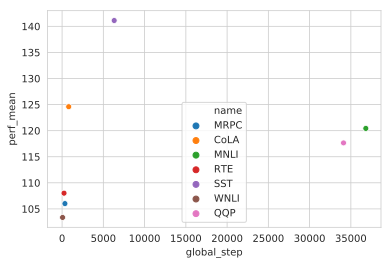

In [24]:
sns.scatterplot(data=df, y="perf_mean", x="global_step", hue="name")